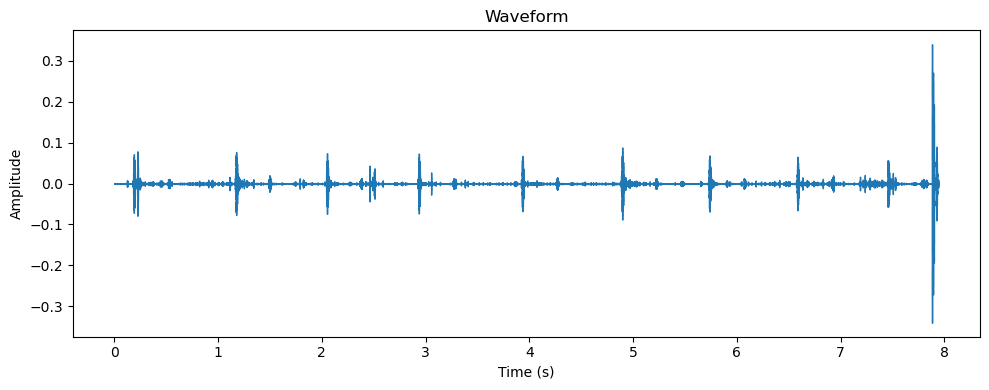

NaN checking
No NaN found
NaN checking
No NaN found
NaN checking
No NaN found
NaN checking
No NaN found
NaN checking
No NaN found
NaN checking
No NaN found
NaN checking
No NaN found
NaN checking
No NaN found
NaN checking
No NaN found
NaN checking
No NaN found
NaN checking
No NaN found
NaN checking
No NaN found
NaN checking
No NaN found
NaN checking
No NaN found
NaN checking
No NaN found
NaN checking
No NaN found
NaN checking
No NaN found
NaN checking
No NaN found
NaN checking
No NaN found
NaN checking
No NaN found
NaN checking
No NaN found
NaN checking
No NaN found
NaN checking
No NaN found
NaN checking
No NaN found
NaN checking
No NaN found
NaN checking
No NaN found
NaN checking
No NaN found
NaN checking
No NaN found
NaN checking
No NaN found
NaN checking
No NaN found
NaN checking
No NaN found
NaN checking
No NaN found
NaN checking
No NaN found
NaN checking
No NaN found
NaN checking
No NaN found
NaN checking
No NaN found
NaN checking
No NaN found
NaN checking
No NaN found
NaN checking

In [1]:
import librosa
import matplotlib.pyplot as plt
import librosa.display
import os
from scipy.signal import butter, filtfilt
import numpy as np

y,sr = librosa.load('normal/201103140135.wav', sr=None)

plt.figure(figsize=(10, 4))
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

#The same signal after BPF


#Segmentation function
def segment_signal(y, fs, window_sec, overlap_sec):
    window_len = int(window_sec * fs)
    stride_len = window_len - int(overlap_sec * fs)
    
    segments = []
    for start in range(0, len(y) - window_len + 1, stride_len):
        end = start + window_len
        segment = y[start:end]
        segments.append(segment)
    return segments

def bandpass_filter(signal, lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

#NaNchecking
def NaN_checking(signal):
    print('NaN checking')
    if np.isnan(signal).any():
        is_nan_array = np.isnan(signal)
        nan_index = np.where(is_nan_array == True)[0]
        for index in nan_index:
            if index == 0:
                signal[index] = 0
            else:
                signal[index] = signal[index-1]
    else:
        print('No NaN found')
    return signal
    

#Amplitude thresholding,input is numpy array of preprocessed trials and labels
def artifact_trial_rejection(train_trials, train_labels, threshold):
    artefact_index = []
    for i in range(len(train_trials)):
        if np.max(np.abs(train_trials[i])) > threshold:
            artefact_index.append(i)
    train_trials = np.delete(train_trials, artefact_index)
    train_labels = np.delete(train_labels, artefact_index)
    print(f'number of removed artefactual trials: {len(artefact_index)}' )

    return train_trials, train_labels


#Segmentation parameters
window_sec = 3
overlap_ratio = 0.5
overlap_sec = window_sec * overlap_ratio

#Preprocessing BPF parameters
lowcut = 25
highcut = 400
order = 4


folder_path_storage = ['normal/', 'murmur/', 'artifact/']
segments_storage = []
labels_storage = []
for folder_path in folder_path_storage:
    file_list = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    
    if folder_path == 'normal/':
        label = 1
    elif folder_path == 'murmur/':
        label = 2
    elif folder_path == 'artifact/':
        label = 3
    for file in file_list:
        #Preprocessing
        y,fs = librosa.load(file, sr=1000)
        NaN_checked_signal = NaN_checking(y)
        bpf_output = bandpass_filter(NaN_checked_signal, lowcut, highcut, fs, order)
        segments = segment_signal(bpf_output, fs, window_sec, overlap_sec)
        for seg in segments:
            segments_storage.append(seg)
            labels_storage.append(label)  


In [2]:
#Some sanity checking
print(len(labels_storage))
print(len(segments_storage))

Trials = np.stack(segments_storage)  
Labels = np.array(labels_storage) 

#print class distribution
print(f'number of normal trials: {np.sum(Labels == 1)}' )
print(f'number of murmur trials: {np.sum(Labels == 2)}' )
print(f'number of artifact trials: {np.sum(Labels == 3)}' )

451
451
number of normal trials: 122
number of murmur trials: 129
number of artifact trials: 200


In [15]:
#Features extraction
from scipy.signal import hilbert, find_peaks
from scipy.stats import entropy as scipy_entropy
from scipy.signal import savgol_filter


peak_amps = [np.max(np.abs(trial)) for trial in Trials]
threshold = np.percentile(peak_amps, 99.5)
print(threshold)

#number of envelope peaks, peak-to-peak amp, entropy, RMS Energy, mean and variance of the envelope
def extract_time_domain_features(signal, sr):
    envelope = np.abs(hilbert(signal))
    envelope_mean = np.mean(envelope)
    envelope_variance = np.var(envelope)
    #number of peaks or dominant frequency of the envelope
    smoothed_env = savgol_filter(envelope, window_length=201, polyorder=2)

    N = len(smoothed_env)
    freqs = np.fft.rfftfreq(N, 1/sr)
    fft_vals = np.abs(np.fft.rfft(smoothed_env))
    #cardiac cycle rate
    envelope_dom_freq = freqs[np.argmax(fft_vals[1:]) + 1] 
    
    rms_energy = np.sqrt(np.mean(signal ** 2))

    p2p = np.max(signal) - np.min(signal)

    hist, bin_edges = np.histogram(signal, bins=50, density=True)
    signal_entropy = scipy_entropy(hist + 1e-8)  

    return np.array([envelope_mean, envelope_variance, envelope_dom_freq, p2p, rms_energy, signal_entropy])

#Bandwidth. Bandpowers. 
def extract_frequency_domain_features(signal, sr):
    freqs_psd, psd = welch(signal, fs=sr, nperseg=1024)
    freq_res = freqs_psd[1] - freqs_psd[0]

    band_25_150 = np.logical_and(freqs_psd >= 25, freqs_psd <= 150)
    band_150_400 = np.logical_and(freqs_psd > 150, freqs_psd <= 400)

    bp_25_150 = np.sum(psd[band_25_150]) * freq_res
    bp_150_400 = np.sum(psd[band_150_400]) * freq_res
    bandpower_ratio = bp_150_400/(bp_25_150 + 1e-8)

    centroid = np.sum(freqs_psd * psd) / (np.sum(psd) + 1e-8)
    bandwidth = np.sqrt(np.sum(((freqs_psd - centroid) ** 2) * psd) / (np.sum(psd) + 1e-8))

    dominant_freq = freqs_psd[np.argmax(psd[1:]) + 1]

    return np.array([bandpower_ratio, bandwidth, dominant_freq])

features = []
for trial in Trials: 
    time_features = extract_time_domain_features(trial, sr=1000)
    freq_features = extract_frequency_domain_features(trial, sr=1000)
    features_vector = np.concatenate((time_features, freq_features))
    features.append(features_vector)

features = np.stack(features)

1.0531505473203977


In [23]:
import random

#Dataset splitting
index = list(range(len(features)))
random.shuffle(index)
features_shuffled = np.array([features[i] for i in index])
labels_shuffled = np.array([Labels[i] for i in index])

train_set = features_shuffled[:int(0.8 * len(index))]
train_set_labels = labels_shuffled[:int(0.8 * len(index))]
test_set = features_shuffled[int(0.8 * len(index)) : int(0.9 * len(index))]
test_set_labels = labels_shuffled[int(0.8 * len(index)) : int(0.9 * len(index))]
val_set = features_shuffled[int(0.9 * len(index)):]
val_set_labels = labels_shuffled[int(0.9 * len(index)):]

In [27]:
#Normalize features (z scoring)
number_of_features = train_set.shape[1]

for feature_id in range (number_of_features):
    feature_mean = np.mean(train_set[:,feature_id])
    feature_std = np.std(train_set[:,feature_id], ddof=0)
    #normalize
    train_set[:,feature_id] = (train_set[:,feature_id] - feature_mean) / feature_std
    test_set[:,feature_id] = (test_set[:,feature_id] - feature_mean) / feature_std
    val_set[:,feature_id] = (val_set[:,feature_id] - feature_mean) / feature_std


9


In [25]:
#Model building


[4.04707420e-04 4.93252671e-02 4.14194625e-03 9.96318202e-04
 4.82632459e-02 2.79906893e-02 1.46336917e-01 1.12201141e-02
 7.10022031e-04 8.09331147e-02 1.05745784e-01 1.81686592e-02
 8.46669391e-02 1.50360411e-01 7.67264604e-02 2.18871131e-02
 3.13501834e-01 7.42077241e-02 6.11353031e-02 1.64025723e-01
 1.78422788e-02 5.44394814e-02 2.22081745e-03 3.61172335e-07
 2.36772216e-02 4.01184369e-03 2.69658322e-01 2.09680832e-01
 3.85441050e-01 4.87191709e-02 2.34380811e-02 5.70379869e-03
 1.58743527e-02 2.20500374e-03 1.48169415e-03 2.59482310e-02
 1.62933821e-03 2.18055861e-02 5.46521544e-02 2.10094264e-02
 1.95261924e-03 7.07984748e-03 3.74810865e-03 2.45289763e-02
 2.55611700e-02 3.63460080e-07]


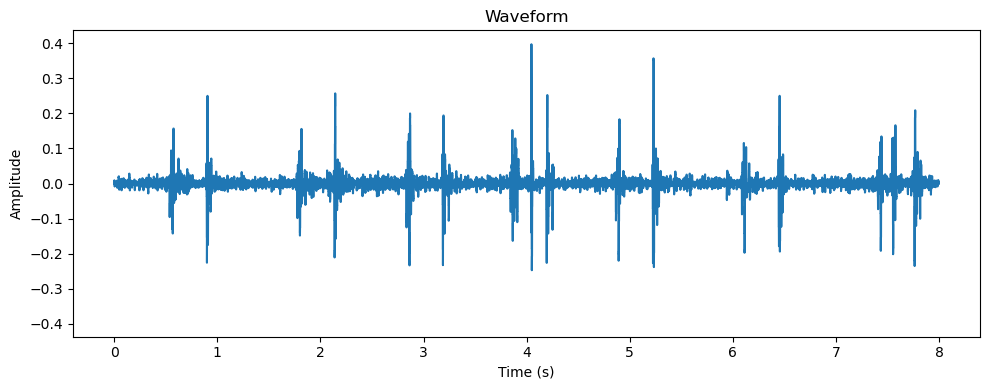

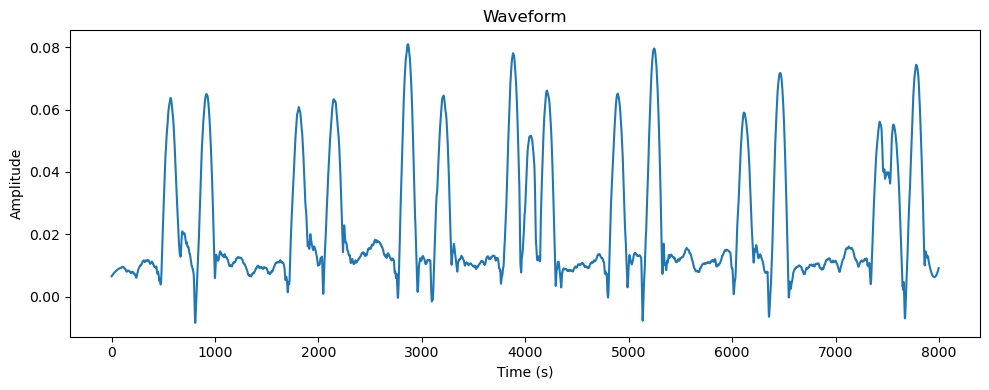

0.8752188047011753
1.664704209829154
0.08736366884815165
91.26932383833581


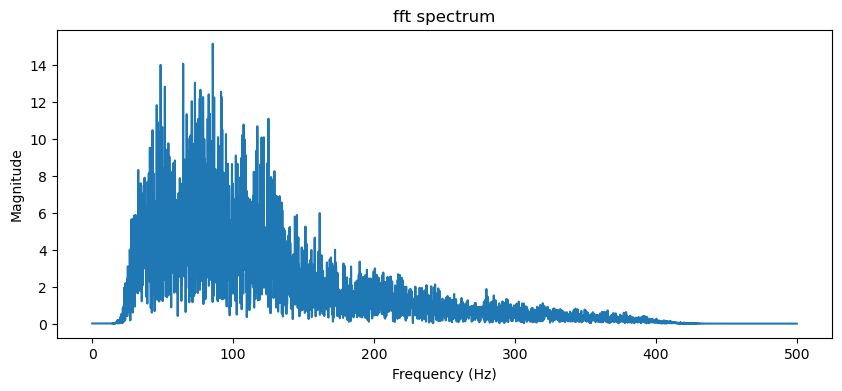

In [4]:
#Miscellanous testing below

from scipy.signal import hilbert, find_peaks
from scipy.signal import savgol_filter
from scipy.stats import entropy as scipy_entropy
from scipy.signal import welch

y,sr = librosa.load('murmur/201108222231.wav', sr=1000)
y,sr = librosa.load('normal/201105021654.wav', sr=1000)

bpf_output = bandpass_filter(y, lowcut, highcut, sr, order)

plt.figure(figsize=(10, 4))
librosa.display.waveshow(bpf_output, sr=sr)
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

envelope = np.abs(hilbert(bpf_output))
smoothed_env = savgol_filter(envelope, window_length=201, polyorder=2)


plt.figure(figsize=(10, 4))
plt.plot(smoothed_env)
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

N = len(smoothed_env)
freqs = np.fft.rfftfreq(N, 1/sr)
fft_vals = np.abs(np.fft.rfft(smoothed_env))
dom_freq = freqs[np.argmax(fft_vals[1:]) + 1]  # skip DC
print(dom_freq)

hist, bin_edges = np.histogram(bpf_output, bins=50, density=True)
signal_entropy = scipy_entropy(hist + 1e-8)  # Avoid log(0)
print(signal_entropy)


#plotting fft spectrum
N = len(bpf_output)
freqs = np.fft.rfftfreq(N, 1/sr)
fft_vals = np.abs(np.fft.rfft(bpf_output))
plt.figure(figsize=(10, 4))
plt.plot(freqs, fft_vals)
plt.title('fft spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')

freqs_psd, psd = welch(bpf_output, fs=sr, nperseg=1024)
freq_res = freqs_psd[1] - freqs_psd[0]

band_25_150 = np.logical_and(freqs_psd >= 25, freqs_psd <= 150)
band_150_400 = np.logical_and(freqs_psd > 150, freqs_psd <= 400)

bp_25_150 = np.sum(psd[band_25_150]) * freq_res
bp_150_400 = np.sum(psd[band_150_400]) * freq_res
print(bp_150_400/bp_25_150)
print(np.sum(freqs_psd * psd) / (np.sum(psd) + 1e-8))

0.1593233530012803
67.39073711423882


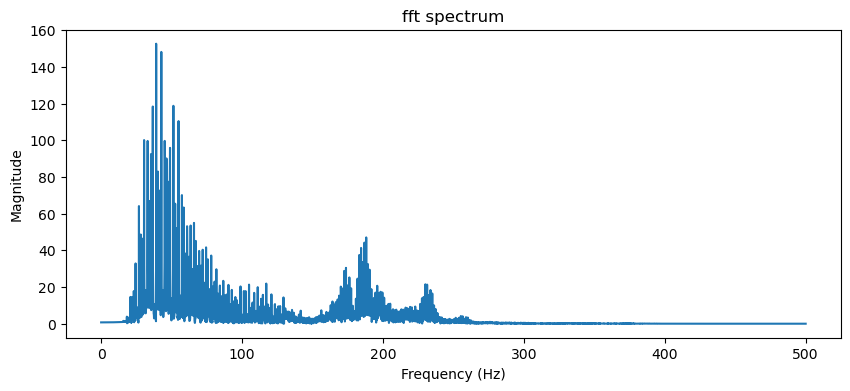

In [5]:
y,sr = librosa.load('murmur/201108222231.wav', sr=1000)
bpf_output = bandpass_filter(y, lowcut, highcut, sr, order)
N = len(bpf_output)
freqs = np.fft.rfftfreq(N, 1/sr)
fft_vals = np.abs(np.fft.rfft(bpf_output))
plt.figure(figsize=(10, 4))
plt.plot(freqs, fft_vals)
plt.title('fft spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')

freqs_psd, psd = welch(bpf_output, fs=sr, nperseg=1024)
freq_res = freqs_psd[1] - freqs_psd[0]

band_25_150 = np.logical_and(freqs_psd >= 25, freqs_psd <= 150)
band_150_400 = np.logical_and(freqs_psd > 150, freqs_psd <= 400)

bp_25_150 = np.sum(psd[band_25_150]) * freq_res
bp_150_400 = np.sum(psd[band_150_400]) * freq_res
print(bp_150_400/bp_25_150)
print(np.sum(freqs_psd * psd) / (np.sum(psd) + 1e-8))